In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import pickle

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- For 3D Plotting ---
from mpl_toolkits.mplot3d import Axes3D

# --- For Progress Bars ---
from tqdm.notebook import tqdm

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
%matplotlib inline
sns.set(style="whitegrid", palette="deep")

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
# Example: CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier, Node # Import Node for pickle
        from RandomForest import RandomForestClassifier # Imports DT/Node internally
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost, DecisionStump, StumpNode # Import dependencies for pickle
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [3]:
# This helper class will be used for LogReg, SVM, MLP, and AdaBoost.
# It automatically handles the binary case (which this is) by
# training just one model.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # This logic is robust: it handles both binary and multi-class cases
        if n_classes <= 2:
            self.binary_le = LabelEncoder() # Use 0/1
            y_binary = self.binary_le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            # Store model keyed by the original "positive" class label (e.g., 1)
            self.models[self.binary_le.classes_[1]] = model 
        else:
            # Multi-class OvR problem
            self.binary_le = None
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if hasattr(self, 'binary_le') and self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             # Map 0/1 predictions back to original labels
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [4]:
# ❗ **ACTION REQUIRED**: Update this path to your Heart Attack CSV file.
DATA_PATH = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\HeartAttack\HeartAttackDataset.csv'

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please update the 'DATA_PATH' variable in this cell.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")

Dataset loaded successfully. Shape: (1319, 9)


In [5]:
print("--- Data Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB

--- Missing Values ---
Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-M

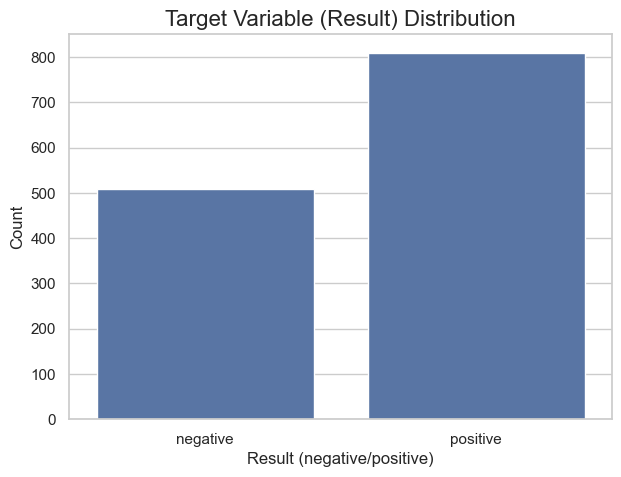

In [6]:
# --- Target Variable: Result ---
plt.figure(figsize=(7, 5))
sns.countplot(x='Result', data=df)
plt.title('Target Variable (Result) Distribution', fontsize=16)
plt.xlabel('Result (negative/positive)')
plt.ylabel('Count')
plt.show()

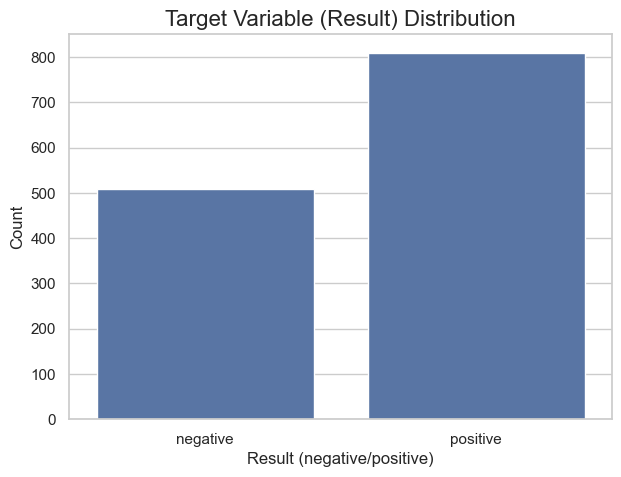

In [7]:
# --- Target Variable: Result ---
plt.figure(figsize=(7, 5))
sns.countplot(x='Result', data=df)
plt.title('Target Variable (Result) Distribution', fontsize=16)
plt.xlabel('Result (negative/positive)')
plt.ylabel('Count')
plt.show()

Generating Pair Plot... (This may take a moment)


<Figure size 2000x2000 with 0 Axes>

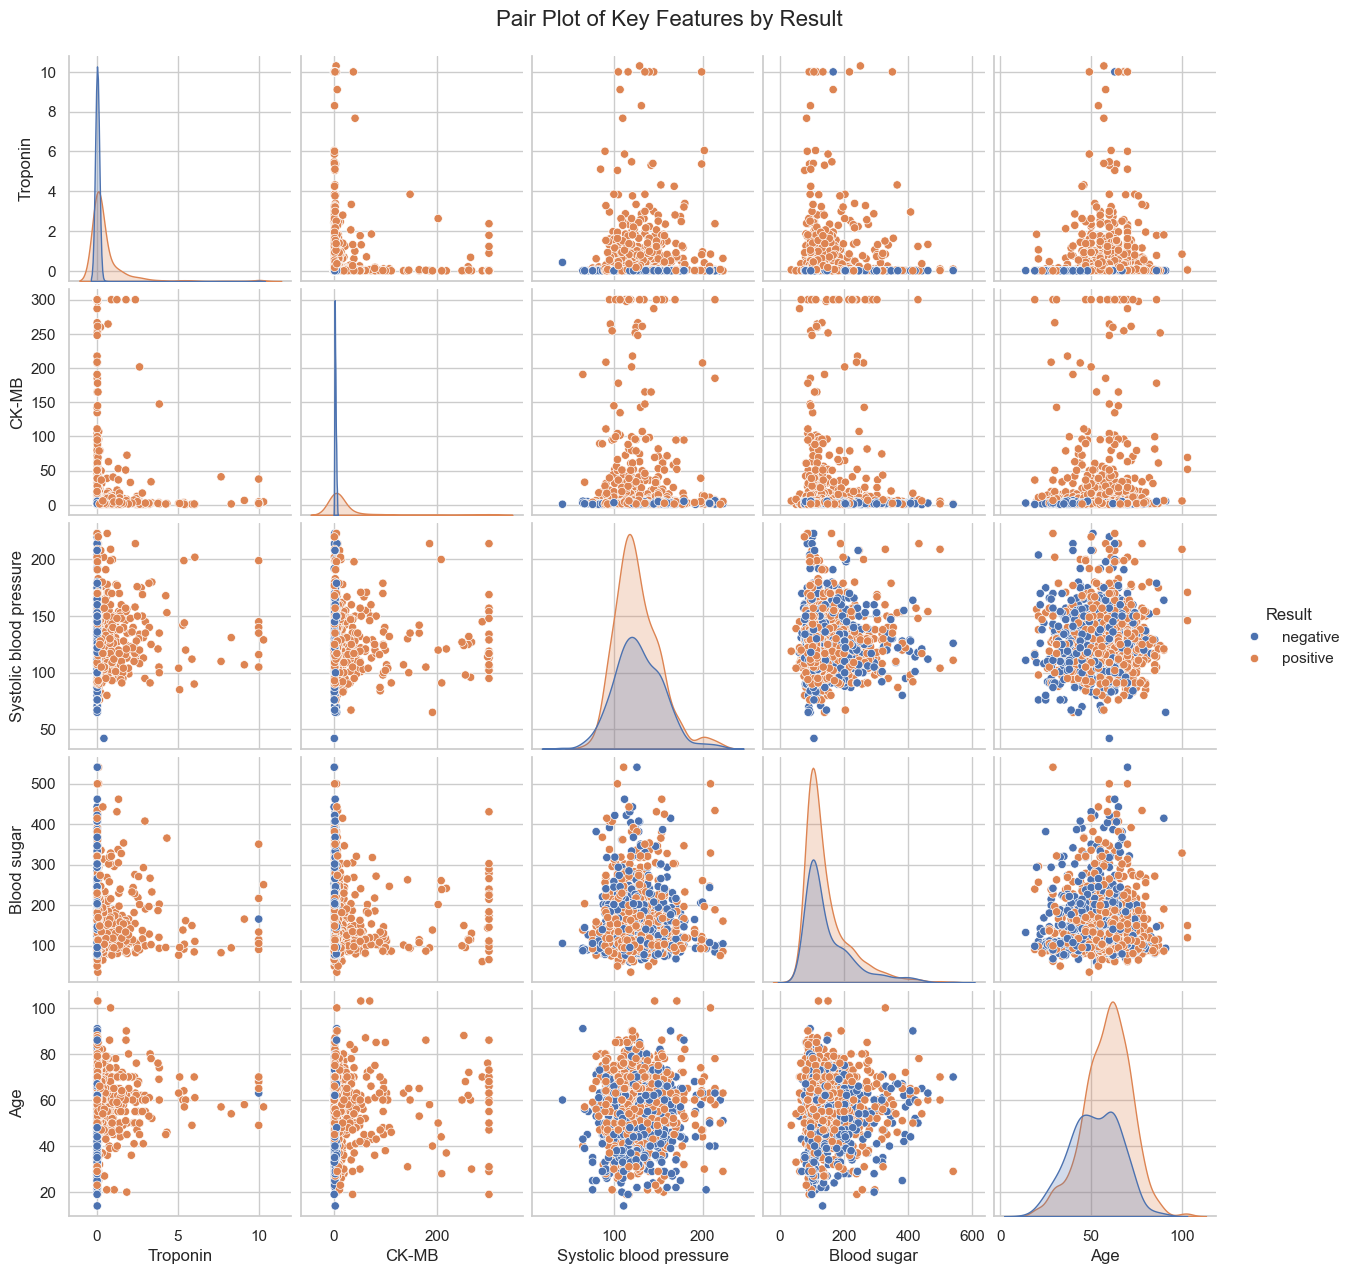

In [8]:
# --- Pair Plot of Key Features by Result ---
print("Generating Pair Plot... (This may take a moment)")
plt.figure(figsize=(20, 20))
# We'll pick the top correlated features + Age
sns.pairplot(df, hue='Result', vars=['Troponin', 'CK-MB', 'Systolic blood pressure', 'Blood sugar', 'Age'])
plt.suptitle('Pair Plot of Key Features by Result', y=1.02, fontsize=16)
plt.show()

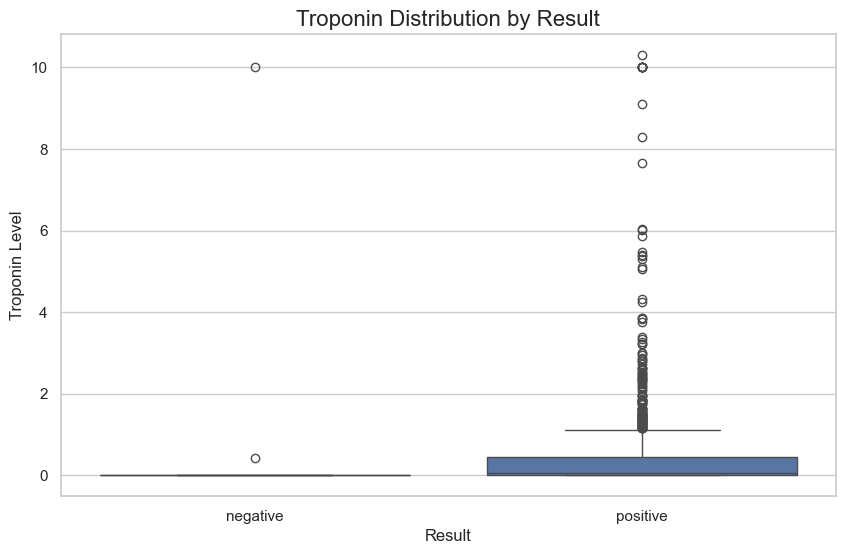

In [9]:
# --- Box Plot: Troponin vs. Result ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Result', y='Troponin')
plt.title('Troponin Distribution by Result', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Troponin Level')
plt.show()

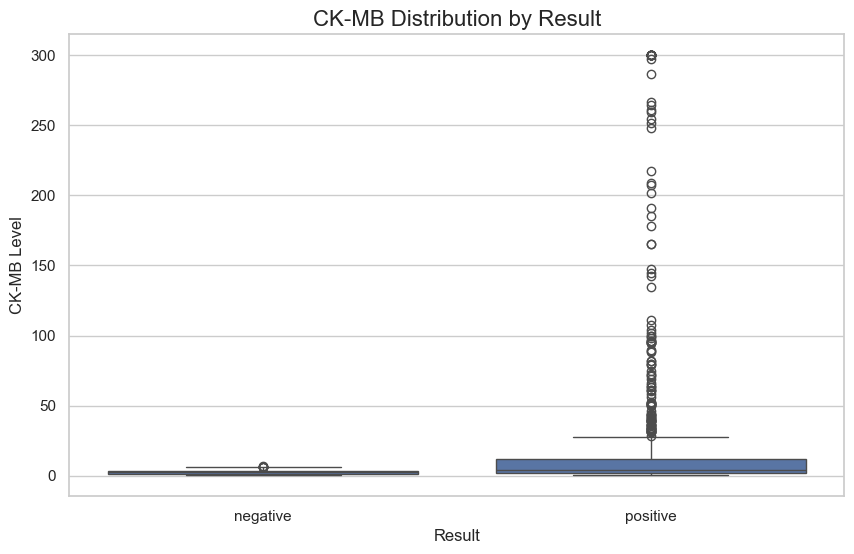

In [10]:
# --- Box Plot: CK-MB vs. Result ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Result', y='CK-MB')
plt.title('CK-MB Distribution by Result', fontsize=16)
plt.xlabel('Result')
plt.ylabel('CK-MB Level')
plt.show()

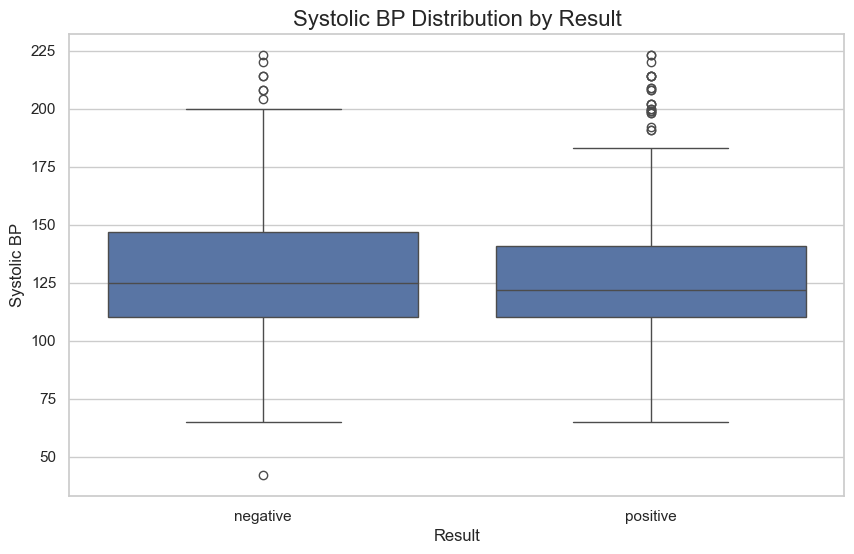

In [11]:
# --- Box Plot: Systolic blood pressure vs. Result ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Result', y='Systolic blood pressure')
plt.title('Systolic BP Distribution by Result', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Systolic BP')
plt.show()

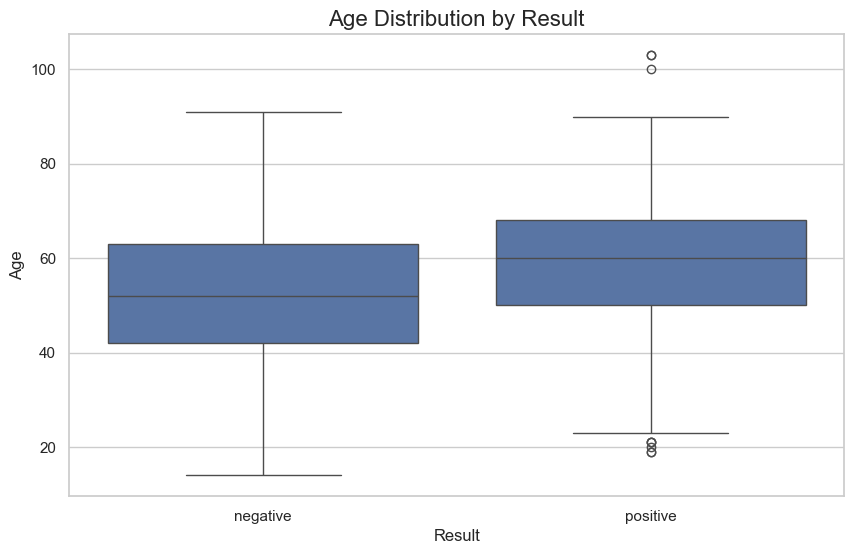

In [12]:
# --- Box Plot: Age vs. Result ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Result', y='Age')
plt.title('Age Distribution by Result', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Age')
plt.show()  

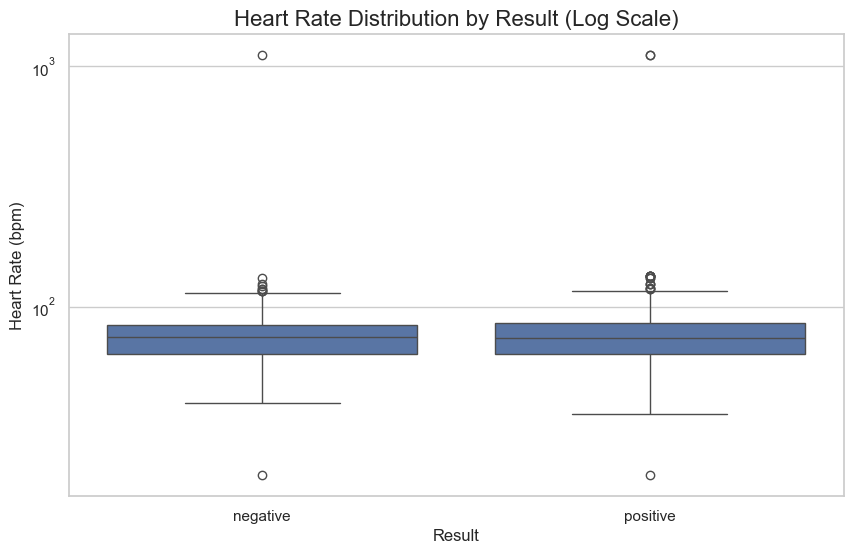

In [13]:
# --- Box Plot: Heart rate (Handling Outlier) ---
plt.figure(figsize=(10, 6))
# We'll use a log scale to see the distribution despite the outlier
sns.boxplot(data=df, x='Result', y='Heart rate')
plt.yscale('log') # Use log scale to show the outlier
plt.title('Heart Rate Distribution by Result (Log Scale)', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Heart Rate (bpm)')
plt.show()

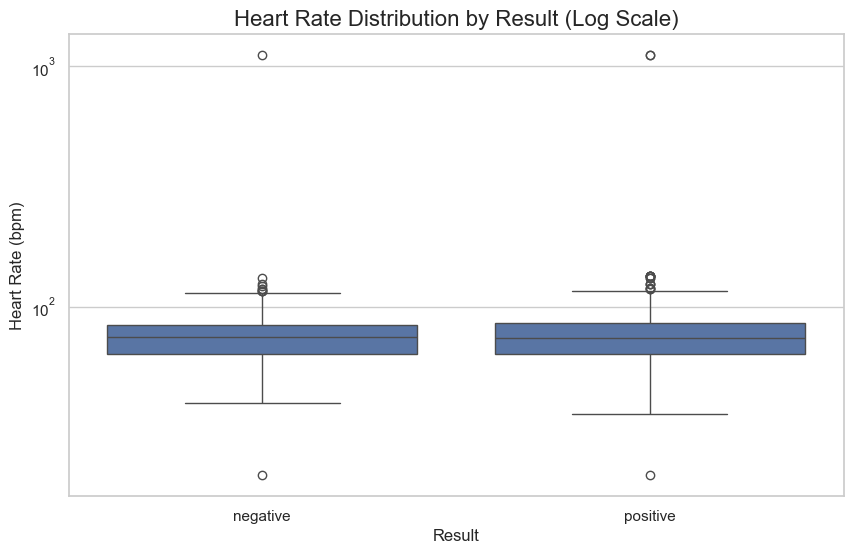

In [14]:
# --- Box Plot: Heart rate (Handling Outlier) ---
plt.figure(figsize=(10, 6))
# We'll use a log scale to see the distribution despite the outlier
sns.boxplot(data=df, x='Result', y='Heart rate')
plt.yscale('log') # Use log scale to show the outlier
plt.title('Heart Rate Distribution by Result (Log Scale)', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Heart Rate (bpm)')
plt.show()

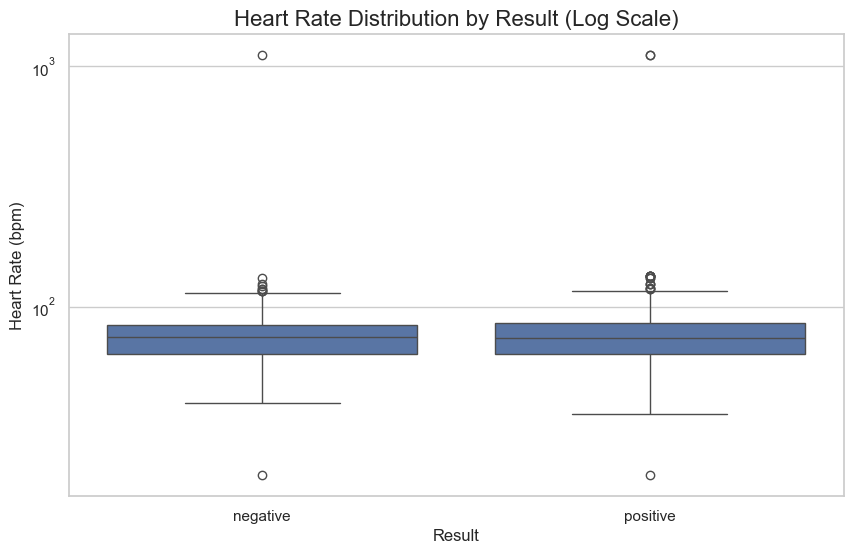

In [15]:
# --- Box Plot: Heart rate (Handling Outlier) ---
plt.figure(figsize=(10, 6))
# We'll use a log scale to see the distribution despite the outlier
sns.boxplot(data=df, x='Result', y='Heart rate')
plt.yscale('log') # Use log scale to show the outlier
plt.title('Heart Rate Distribution by Result (Log Scale)', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Heart Rate (bpm)')
plt.show()

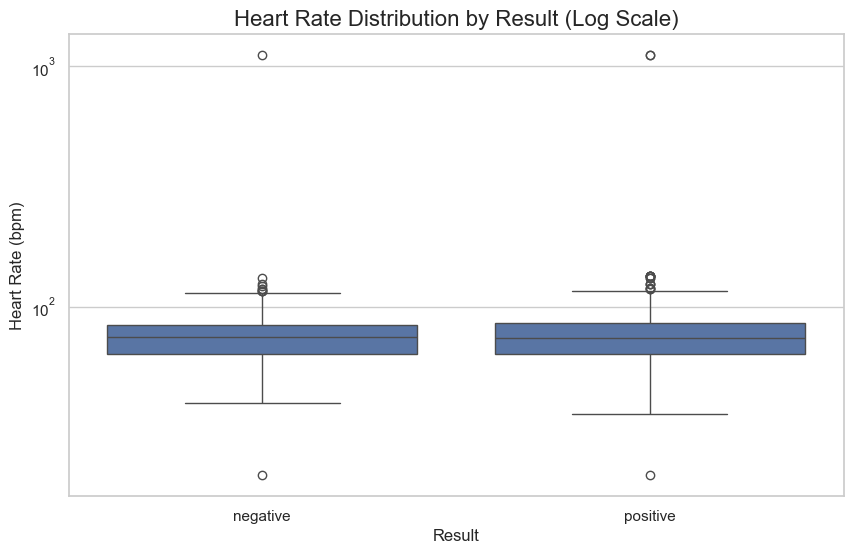

In [16]:
# --- Box Plot: Heart rate (Handling Outlier) ---
plt.figure(figsize=(10, 6))
# We'll use a log scale to see the distribution despite the outlier
sns.boxplot(data=df, x='Result', y='Heart rate')
plt.yscale('log') # Use log scale to show the outlier
plt.title('Heart Rate Distribution by Result (Log Scale)', fontsize=16)
plt.xlabel('Result')
plt.ylabel('Heart Rate (bpm)')
plt.show()

Generating 3D Scatter Plot...


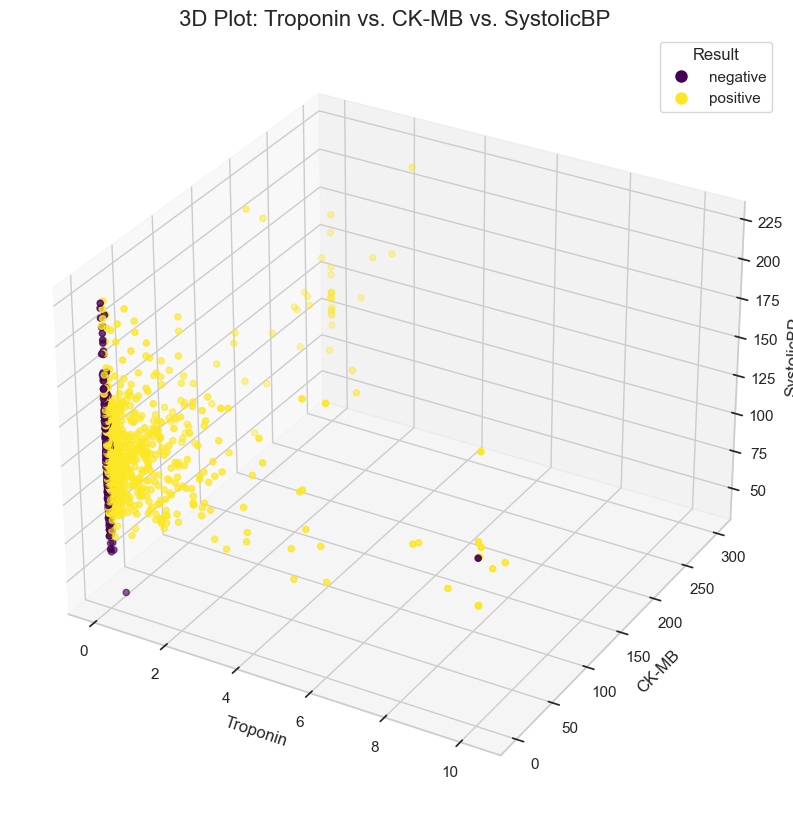

In [17]:
# --- 3D Scatter Plot: Troponin vs. CK-MB vs. SystolicBP ---
print("Generating 3D Scatter Plot...")
le_3d = LabelEncoder()
colors_3d = le_3d.fit_transform(df['Result'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Troponin'], 
    df['CK-MB'], 
    df['Systolic blood pressure'], 
    c=colors_3d, 
    cmap='viridis',
    s=20
)

ax.set_title('3D Plot: Troponin vs. CK-MB vs. SystolicBP', fontsize=16)
ax.set_xlabel('Troponin')
ax.set_ylabel('CK-MB')
ax.set_zlabel('SystolicBP')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=c,
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i, c in enumerate(le_3d.classes_)]
ax.legend(handles=legend_elements, title='Result')
plt.show()

Generating 3D Scatter Plot...


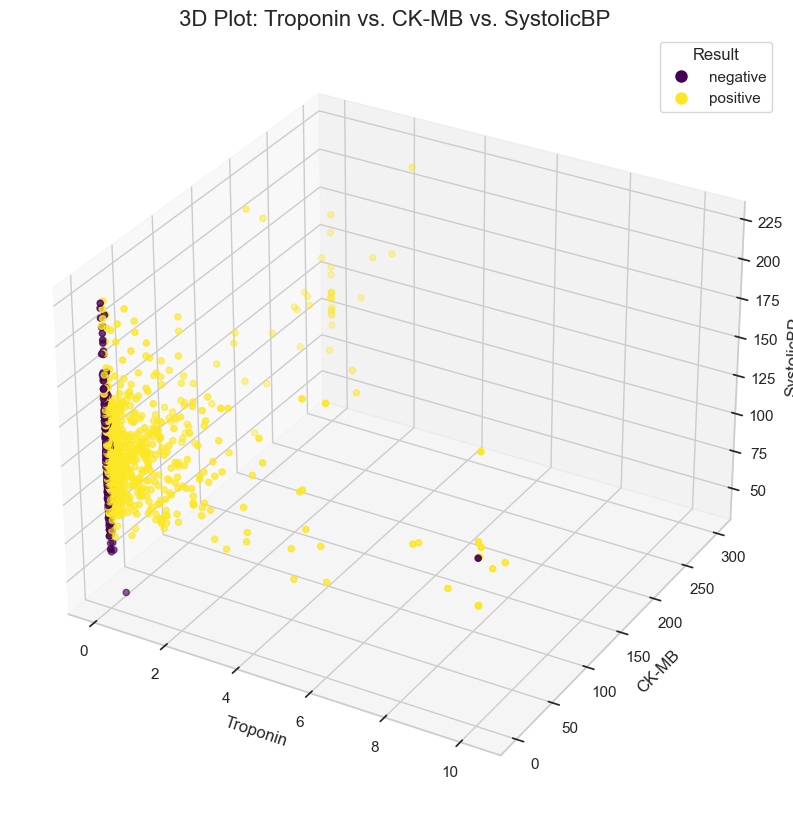

In [18]:
# --- 3D Scatter Plot: Troponin vs. CK-MB vs. SystolicBP ---
print("Generating 3D Scatter Plot...")
le_3d = LabelEncoder()
colors_3d = le_3d.fit_transform(df['Result'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Troponin'], 
    df['CK-MB'], 
    df['Systolic blood pressure'], 
    c=colors_3d, 
    cmap='viridis',
    s=20
)

ax.set_title('3D Plot: Troponin vs. CK-MB vs. SystolicBP', fontsize=16)
ax.set_xlabel('Troponin')
ax.set_ylabel('CK-MB')
ax.set_zlabel('SystolicBP')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=c,
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i, c in enumerate(le_3d.classes_)]
ax.legend(handles=legend_elements, title='Result')
plt.show()

In [19]:
# --- Clean Outlier ---
# Based on EDA 6 and 11, the max 'Heart rate' of 1111 is an error.
# A reasonable max human heart rate is ~220. We'll cap it.
# A more robust method might remove the row, but capping is safer.
original_max = df['Heart rate'].max()
df['Heart rate'] = df['Heart rate'].apply(lambda x: 220 if x > 220 else x)
print(f"Capped 'Heart rate' outlier. Max value changed from {original_max} to {df['Heart rate'].max()}")

Capped 'Heart rate' outlier. Max value changed from 1111 to 220


In [20]:
# --- Train-Test Split ---
# Define X (features) and y (target)
X = df.drop('Result', axis=1)
y = df['Result']

# We use stratify=y because the dataset is imbalanced (see EDA 7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1055, 8)
X_test shape: (264, 8)
y_train shape: (1055,)
y_test shape: (264,)


In [21]:
# --- Define Preprocessing Pipeline ---
# All features are numeric and continuous (or can be treated as such)
ALL_FEATURES = list(X.columns)
print(f"All {len(ALL_FEATURES)} features will be treated as numeric.")

# Pipeline: 1. Impute (just in case), 2. Scale
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

print("Preprocessing pipeline (Imputer + StandardScaler) defined.")

# --- Apply the Pipeline ---
print("Fitting and transforming X_train...")
X_train_processed = preprocessor.fit_transform(X_train)
print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test)

# --- Label Encode Target ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
class_names = le.classes_

print(f"\nPreprocessing complete.")
print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Target classes (encoded): {list(zip(le.classes_, np.unique(y_train_enc)))}")

All 8 features will be treated as numeric.
Preprocessing pipeline (Imputer + StandardScaler) defined.
Fitting and transforming X_train...
Transforming X_test...

Preprocessing complete.
Processed X_train shape: (1055, 8)
Target classes (encoded): [('negative', 0), ('positive', 1)]


In [22]:
# --- Define Model Pipeline ---
print("Defining all 9 from-scratch models...")
n_features_final = X_train_processed.shape[1] # This will be 8

# Use "Better Accuracy" parameters
multi_class_models = {
    "KNN": KNN(k=5),
    "GNB": GaussianNaiveBayes(),
    "LDA": LDA(),
    "DT": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "RF": RandomForestClassifier(n_trees=100, max_depth=10, min_samples_split=5),
}

# Binary models wrapped in OvR
binary_models_to_wrap = {
    "LogReg_OvR": (LogisticRegression, 
                   {"learning_rate": 0.01, "n_iters": 1000, "verbose": False}),
    "SVM_OvR": (LinearSVM, 
                {"learning_rate": 0.001, "lambda_param": 0.01, "n_iters": 1000, "verbose": False}),
    "MLP_OvR": (SimpleMLP, 
                {"n_input": n_features_final, "n_hidden": 8, "n_output": 1,
                 "learning_rate": 0.01, "n_iters": 1000, "verbose": False, 
                 "activation": 'relu'}),
    "AdaBoost_OvR": (AdaBoost, {"n_estimators": 50}),
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")
print("Models to run:", list(all_models.keys()))

Defining all 9 from-scratch models...
Total models to train: 9
Models to run: ['KNN', 'GNB', 'LDA', 'DT', 'RF', 'LogReg_OvR', 'SVM_OvR', 'MLP_OvR', 'AdaBoost_OvR']


In [23]:
# --- Run All Models ---
results = {}
reports = {}
models_trained = {} # To store the trained model instances

print("\n--- Running Model Benchmarks on Processed Data ---")

# Wrap the model loop with tqdm for a progress bar
for name, model in tqdm(all_models.items(), desc="Overall Model Progress"):
    try:
        start_time = time.time()
        
        # Train the model
        model.fit(X_train_processed, y_train_enc)
        
        # Predict
        y_pred = model.predict(X_test_processed)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_enc, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model # Save the trained model
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)

print("\nAll models trained and evaluated.")


--- Running Model Benchmarks on Processed Data ---


Overall Model Progress:   0%|          | 0/9 [00:00<?, ?it/s]

KNN fitted with 1055 samples.
Predicting for 264 samples using KNN (k=5)...
Fitting Gaussian Naive Bayes...
Fitting complete.
Predicting labels for 264 samples using GNB...
Fitting LDA...
LDA fitting complete.
Predicting labels for 264 samples using LDA...
Fitting Decision Tree: max_depth=10, min_split=5, features_per_split=8...
Tree fitting complete.
Predicting labels for 264 samples using Decision Tree...
Fitting Random Forest: 100 trees, max_depth=10, min_split=5, features_per_split=2...
  Tree 10/100 fitted.
  Tree 20/100 fitted.
  Tree 30/100 fitted.
  Tree 40/100 fitted.
  Tree 50/100 fitted.
  Tree 60/100 fitted.
  Tree 70/100 fitted.
  Tree 80/100 fitted.
  Tree 90/100 fitted.
  Tree 100/100 fitted.
Random Forest fitting complete.
Predicting labels for 264 samples using Random Forest (100 trees)...
Starting Logistic Regression training for up to 1000 iterations...
Convergence reached at iteration 411. Cost = 0.596480
Predicting labels for 264 samples using Logistic Regression..

In [24]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Format accuracy as percentage
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")

print(results_df.to_string())



🏁 FINAL ACCURACY SUMMARY 🏁

          Model Accuracy
0            RF   98.48%
1  AdaBoost_OvR   98.48%
2            DT   98.11%
3    LogReg_OvR   71.21%
4       SVM_OvR   70.83%
5           LDA   70.08%
6           GNB   69.70%
7       MLP_OvR   66.67%
8           KNN   62.88%


In [25]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model (re-sorting by number)
best_model_name = sorted(results.items(), key=lambda item: item[1], reverse=True)[0][0]
best_accuracy = results[best_model_name]

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy*100:.2f}%)")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed



--- 🏆 Best Model ---
RF (Accuracy: 98.48%)

--- Classification Report for Best Model ---
              precision    recall  f1-score     support
negative       0.980392  0.980392  0.980392  102.000000
positive       0.987654  0.987654  0.987654  162.000000
accuracy       0.984848  0.984848  0.984848    0.984848
macro avg      0.984023  0.984023  0.984023  264.000000
weighted avg   0.984848  0.984848  0.984848  264.000000


Predicting labels for 264 samples using Random Forest (100 trees)...


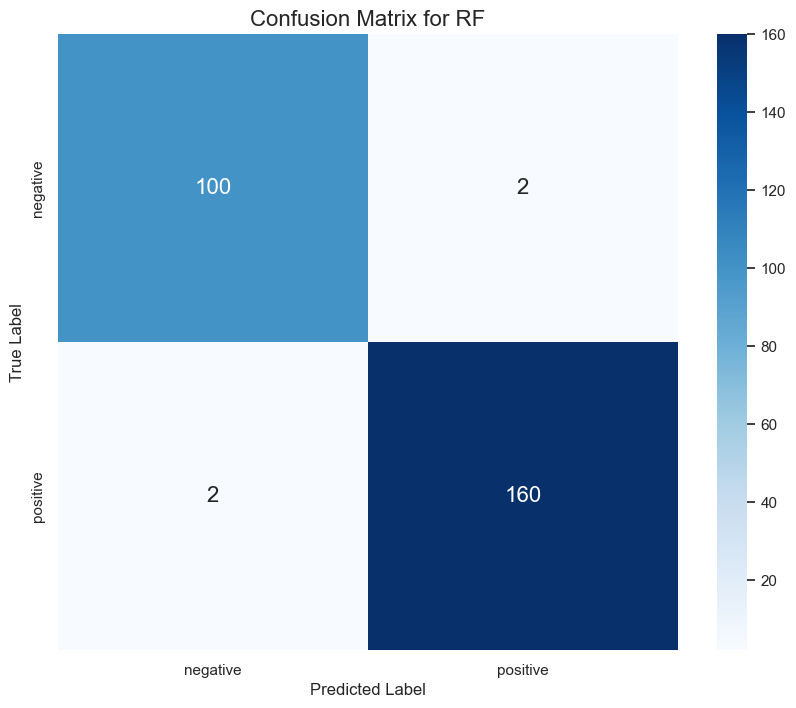

In [26]:
# --- Confusion Matrix for Best Model ---

# Get the trained model instance
best_model_instance = models_trained[best_model_name]
y_pred_best = best_model_instance.predict(X_test_processed)

cm = confusion_matrix(y_test_enc, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 16})
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()